In [25]:
import pandas as pd
import numpy as np

import dill as pickle
import os

from CB_utils import *

In [122]:
with open("input/data_cleaned2.pkl", "rb") as f:
    data = pickle.load(f)

train = data["train"]
test = data["test"]

In [30]:
from sklearn.model_selection import train_test_split,StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import log_loss,roc_auc_score
from catboost import CatBoostClassifier, Pool

SEED = 62
target = "type"
features = [c for c in train.columns if c not in [target, 'id']]
feature_importance = pd.DataFrame()

X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target], 
                                                      test_size=0.1, random_state=SEED,
                                                      shuffle = True,
                                                      stratify = train[target])

trn_data = Pool(data = X_train, label = y_train)
val_data = Pool(data = X_valid, label = y_valid)

params = {"iterations" : 10000,
          "loss_function" : "MultiClass",}
    
model = CatBoostClassifier(**params,
                           random_seed = SEED,
                           task_type="GPU")

fit_model = model.fit(trn_data,
                     eval_set = val_data,
                     use_best_model = True,
                     verbose = 2000,
                     plot = False)

p_valid = fit_model.predict_proba(X_valid)
yp = fit_model.predict_proba(test[features])

0:	learn: 2.6594066	test: 2.6593125	best: 2.6593125 (0)	total: 27.7ms	remaining: 4m 37s
2000:	learn: 0.3629284	test: 0.3910368	best: 0.3910368 (2000)	total: 46s	remaining: 3m 3s
4000:	learn: 0.3223388	test: 0.3734958	best: 0.3734958 (4000)	total: 1m 32s	remaining: 2m 18s
6000:	learn: 0.2950328	test: 0.3665709	best: 0.3665709 (6000)	total: 2m 18s	remaining: 1m 32s
8000:	learn: 0.2727658	test: 0.3631316	best: 0.3631316 (8000)	total: 3m 5s	remaining: 46.3s
9999:	learn: 0.2536751	test: 0.3613492	best: 0.3613298 (9985)	total: 3m 51s	remaining: 0us
bestTest = 0.3613297852
bestIteration = 9985
Shrink model to first 9986 iterations.


In [ ]:
feature_importance = pd.DataFrame()

In [ ]:
p_valid = fit_model.predict_proba(X_valid[features])[:,1]
log_loss = log_loss(y_valid, p_valid)
feature_importance["feature"] = features
feature_importance["importance"] = model.get_feature_importance(val_data,type='LossFunctionChange')
print(f'log_loss: {log_loss:.5}')

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(24,30))
sns.barplot(x="importance", y="feature", data=feature_importance.sort_values(by="importance", ascending=False)[0:100]);
plt.title('Catboost Importance');

### OneHotEncoding

결론: Training error 증가, validation 도 증가

training_loss : 0.3422758811551689  
validation_loss : 0.395301220703125

기각

### Test 와 Train 의 Distplot

1. train 에서 대부분의 column 들이 굉장히 작은값을 가지고 있는 경우가 많음(outlier) ex) -4000000
    추가 : 큰 값도 가지고있음
    - 밝기에서 - 값은 무엇을 의미?? : 더 밝다는 것을 의미한다
    - 후보 1 : test 값의 min 보다 작으면 -40000 만큼 밝던 -400만큼 밝던 그냥 밝은 것을 의미하기 때문에 test 데이터의 최소값 - 1으로 encoding한다
    - 후보 2 : test 데이터의 범위에 없으면 지워버린다
    - 후보 3 : Boxplot 의 outlier 검출법을 통해 지워버린다  
        => 후보3 의 문제점 : test data도 그러면 outlier 라고 할것이 생긴다.
    - 후보 4 : 후보 2 + 후보 3 test 데이터의 최대값 + 1.5 IOR 을 넘는 obs 는 지워버린다
        => 지워버리는 후보들의 문제점 : 너무 많은 obs가 지워져 정보손실이 생길 수 있음

### 후보 1

In [110]:
light = [c for c in train.columns if c not in ["id","type","fiberID"]]

In [111]:
for feature in light:
    train[feature] = train[feature].apply(lambda x : test[feature].min() - 1 if x < test[feature].min() else x)
    train[feature] = train[feature].apply(lambda x : test[feature].max() + 1 if x > test[feature].max() else x)

In [39]:
SEED = 42
target = "type"
features = [c for c in train.columns if c not in [target, 'id']]
feature_importance = pd.DataFrame()

X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target], 
                                                      test_size=0.1, random_state=SEED,
                                                      shuffle = True,
                                                      stratify = train[target])

trn_data = Pool(data = X_train, label = y_train)
val_data = Pool(data = X_valid, label = y_valid)

params = {"iterations" : 10000,
          "loss_function" : "MultiClass",}
    
model = CatBoostClassifier(**params,
                           random_seed = SEED,
                           task_type="GPU")

fit_model = model.fit(trn_data,
                     eval_set = val_data,
                     use_best_model = True,
                     verbose = 2000,
                     plot = False)

p_valid = fit_model.predict_proba(X_valid)
yp = fit_model.predict_proba(test[features])

0:	learn: 2.6601261	test: 2.6615744	best: 2.6615744 (0)	total: 26.8ms	remaining: 4m 27s
2000:	learn: 0.3622677	test: 0.4002034	best: 0.4002034 (2000)	total: 46.4s	remaining: 3m 5s
4000:	learn: 0.3208986	test: 0.3817246	best: 0.3817246 (4000)	total: 1m 32s	remaining: 2m 18s
6000:	learn: 0.2930563	test: 0.3749512	best: 0.3749512 (6000)	total: 2m 17s	remaining: 1m 31s
8000:	learn: 0.2710957	test: 0.3714960	best: 0.3714896 (7997)	total: 3m 4s	remaining: 46s
9999:	learn: 0.2528087	test: 0.3697088	best: 0.3697043 (9972)	total: 3m 49s	remaining: 0us
bestTest = 0.3697042725
bestIteration = 9972
Shrink model to first 9973 iterations.


In [40]:
training_loss = fit_model.get_best_score()["learn"]["MultiClass"]
validation_loss = fit_model.get_best_score()["validation"]["MultiClass"]
print(training_loss)
print(validation_loss)

0.2528086690792873
0.3697042724609375


In [59]:
train = train.drop("type", axis =1)
train["test"] = 0
test["test"] = 1
total = pd.concat([train, test], axis = 0)
features = total.columns[1:]

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
def plot_feature_distribution(df, features, target = None, save = False, filename =  "",params = {}):
    """
    feature들의 histogram 그려주는 함수
    argument:
        df - (pd.dataframe) DataFrame
        features - 그릴 feature 들
    """
    GRID = 5
    if target != None:
        ntarget = df[target].value_counts().keys().values #(string np.array) target feature의 class 확인
        subdf = [df.loc[df[target] == label] for label in ntarget] #(df list) df grouped by target, ntarget key 순서
    i = 0
    plt.figure()
    fig, ax = plt.subplots(GRID,GRID,figsize=(24,30))

    for feature in features:
        i += 1
        plt.subplot(GRID,GRID,i)
        if target != None:
            for _i,label in enumerate(ntarget):
                sns.distplot(subdf[_i][feature], hist=True,label=label,**params)
        else:
            sns.distplot(df[feature], hist=True, **params)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=13, pad=0)
        plt.tick_params(axis='y', which='major', labelsize=10)
        #plt.legend()
    if save == True:
        plt.savefig(filename)

<Figure size 432x288 with 0 Axes>

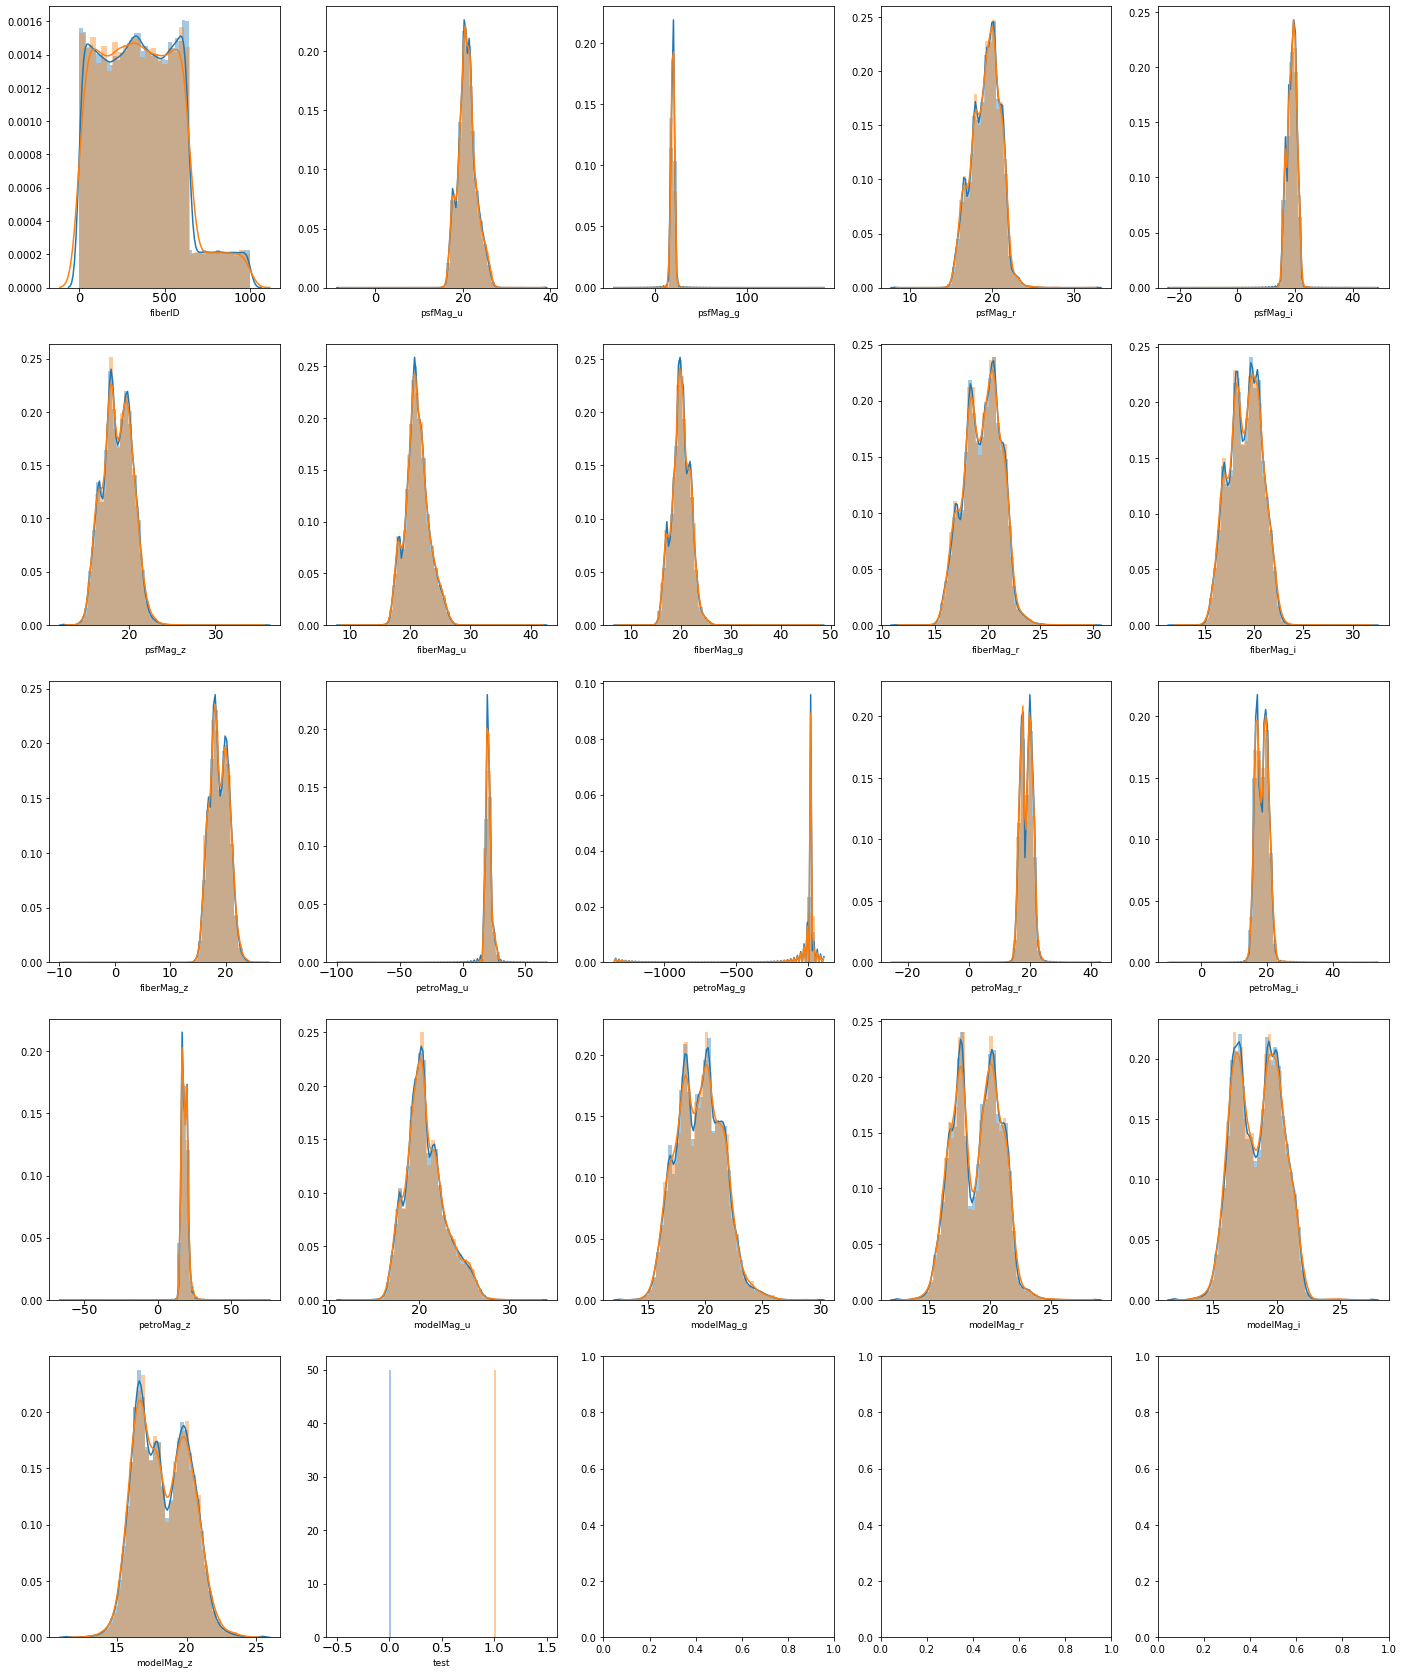

In [62]:
plot_feature_distribution(total, features, target = "test", save = False, filename = "eda/distplot/total.png")

<Figure size 432x288 with 0 Axes>

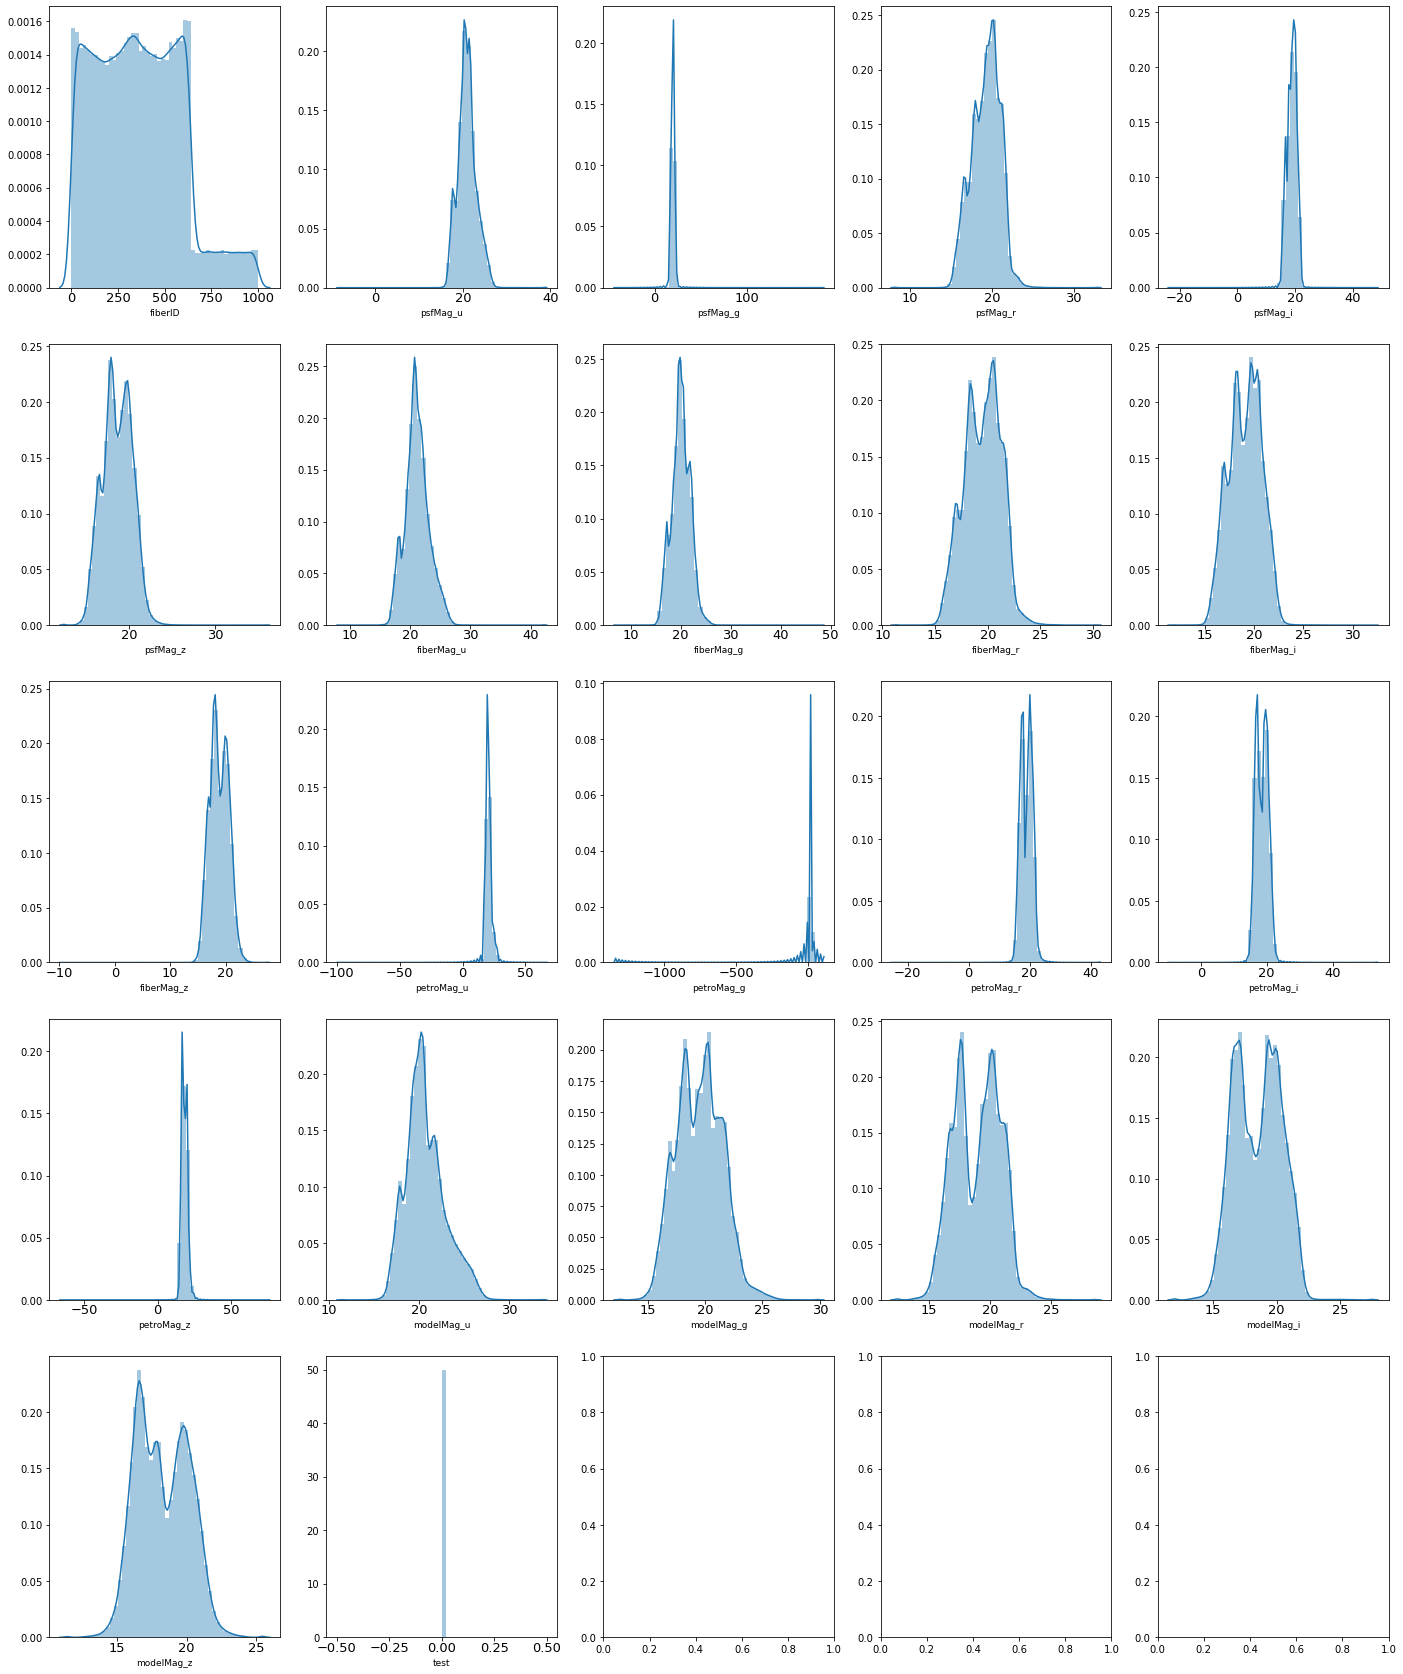

In [63]:
plot_feature_distribution(train, features, target = "test", save = False, filename = "eda/distplot/train.png")

<Figure size 432x288 with 0 Axes>

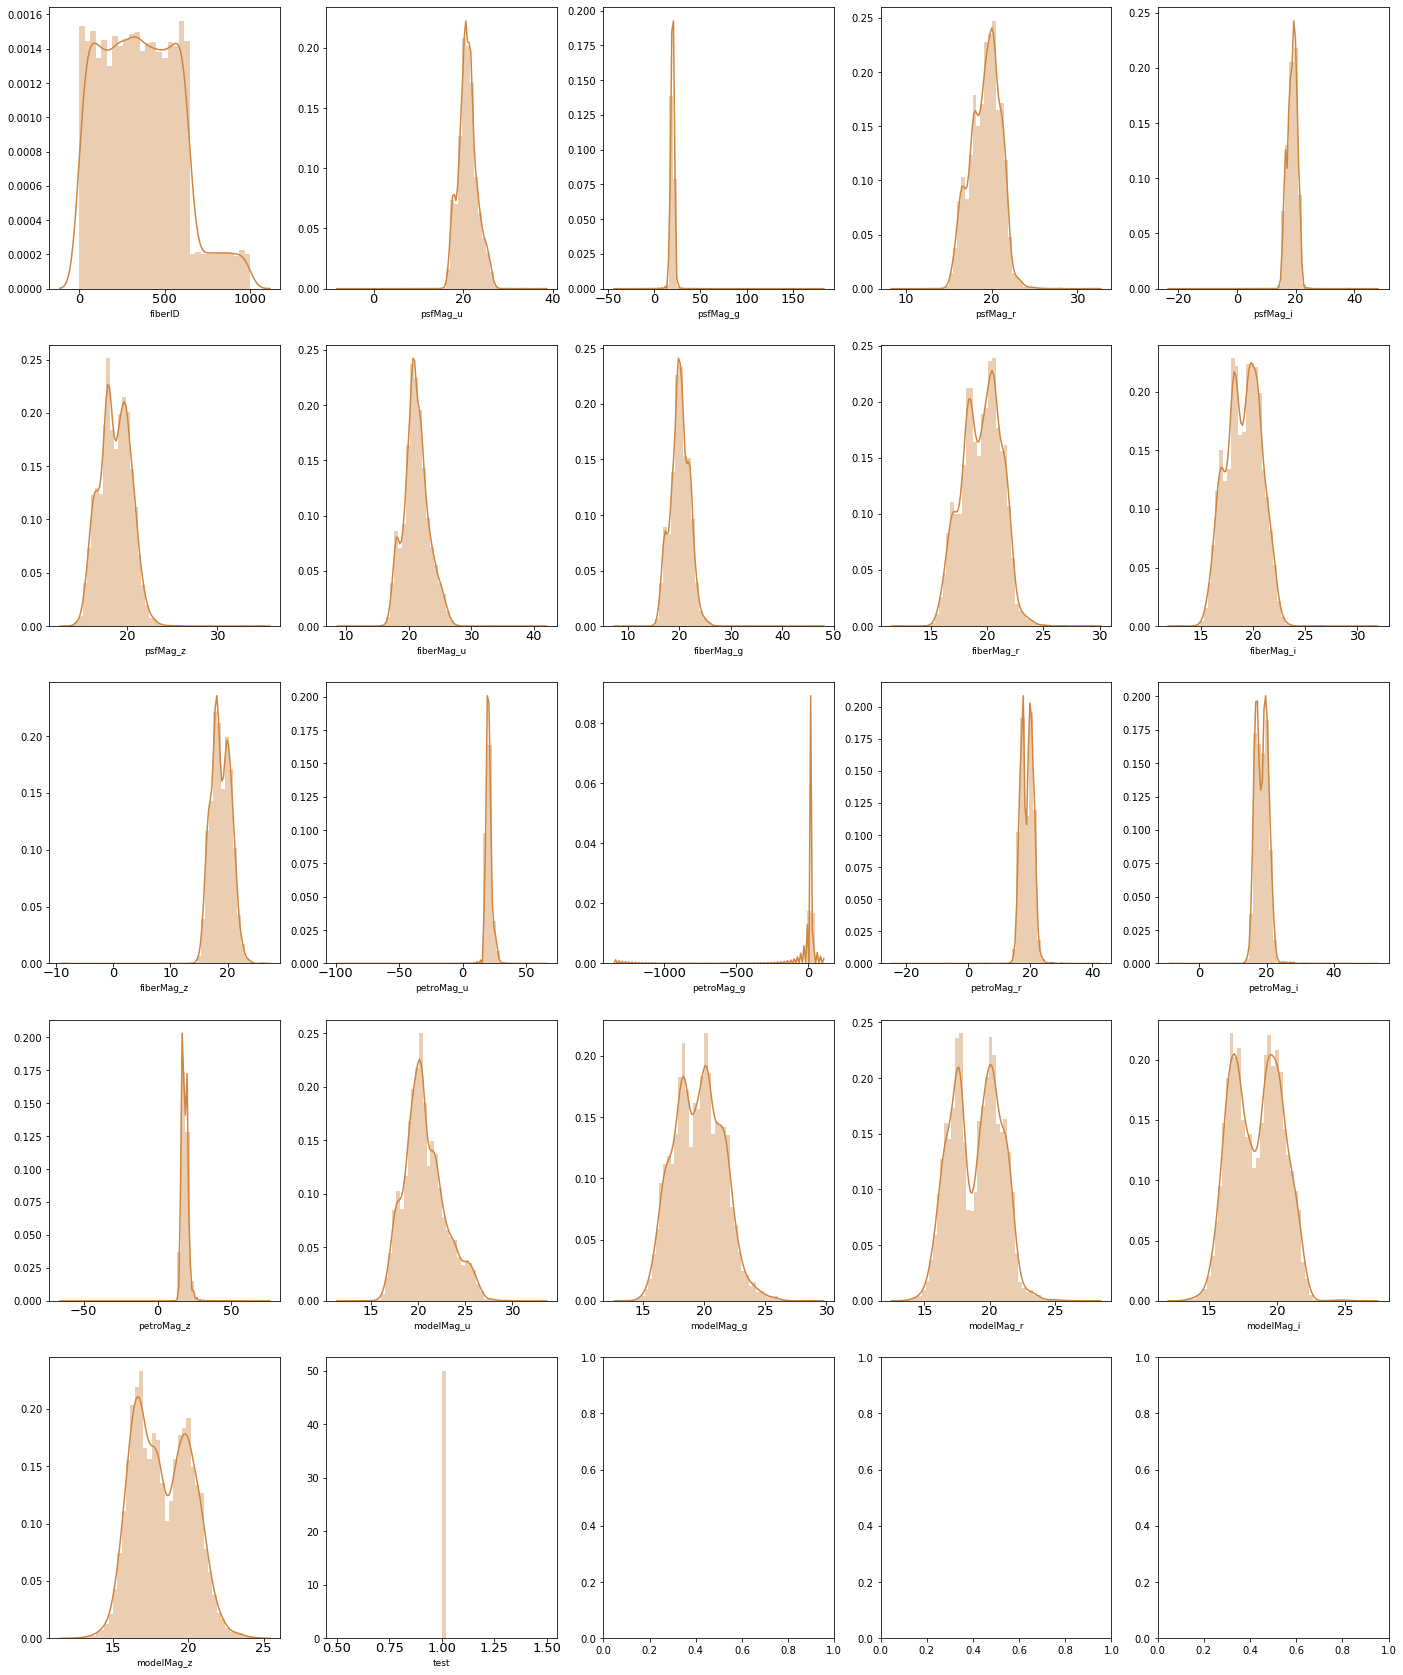

In [64]:
plot_feature_distribution(test, features, target = "test", save = False, filename = "eda/distplot/test.png", params = {"color" : "peru"})

In [112]:
data = {"train" : train,
       "test" : test}

In [113]:
with open("data_outlierMinMax","wb") as f:
    pickle.dump(data,f)

### 후보 4

In [141]:
for feature in light:
    outlier_max = train[feature][train[feature] > test[feature].max() + 1.5 * (test[feature].quantile(0.75) - test[feature].quantile(0.25))].index
    outlier_min = train[feature][train[feature] < test[feature].min() - 1.5 * (test[feature].quantile(0.75) - test[feature].quantile(0.25))].index
    train = train.drop(outlier_max,axis = 0)
    train = train.drop(outlier_min,axis = 0)

<Figure size 432x288 with 0 Axes>

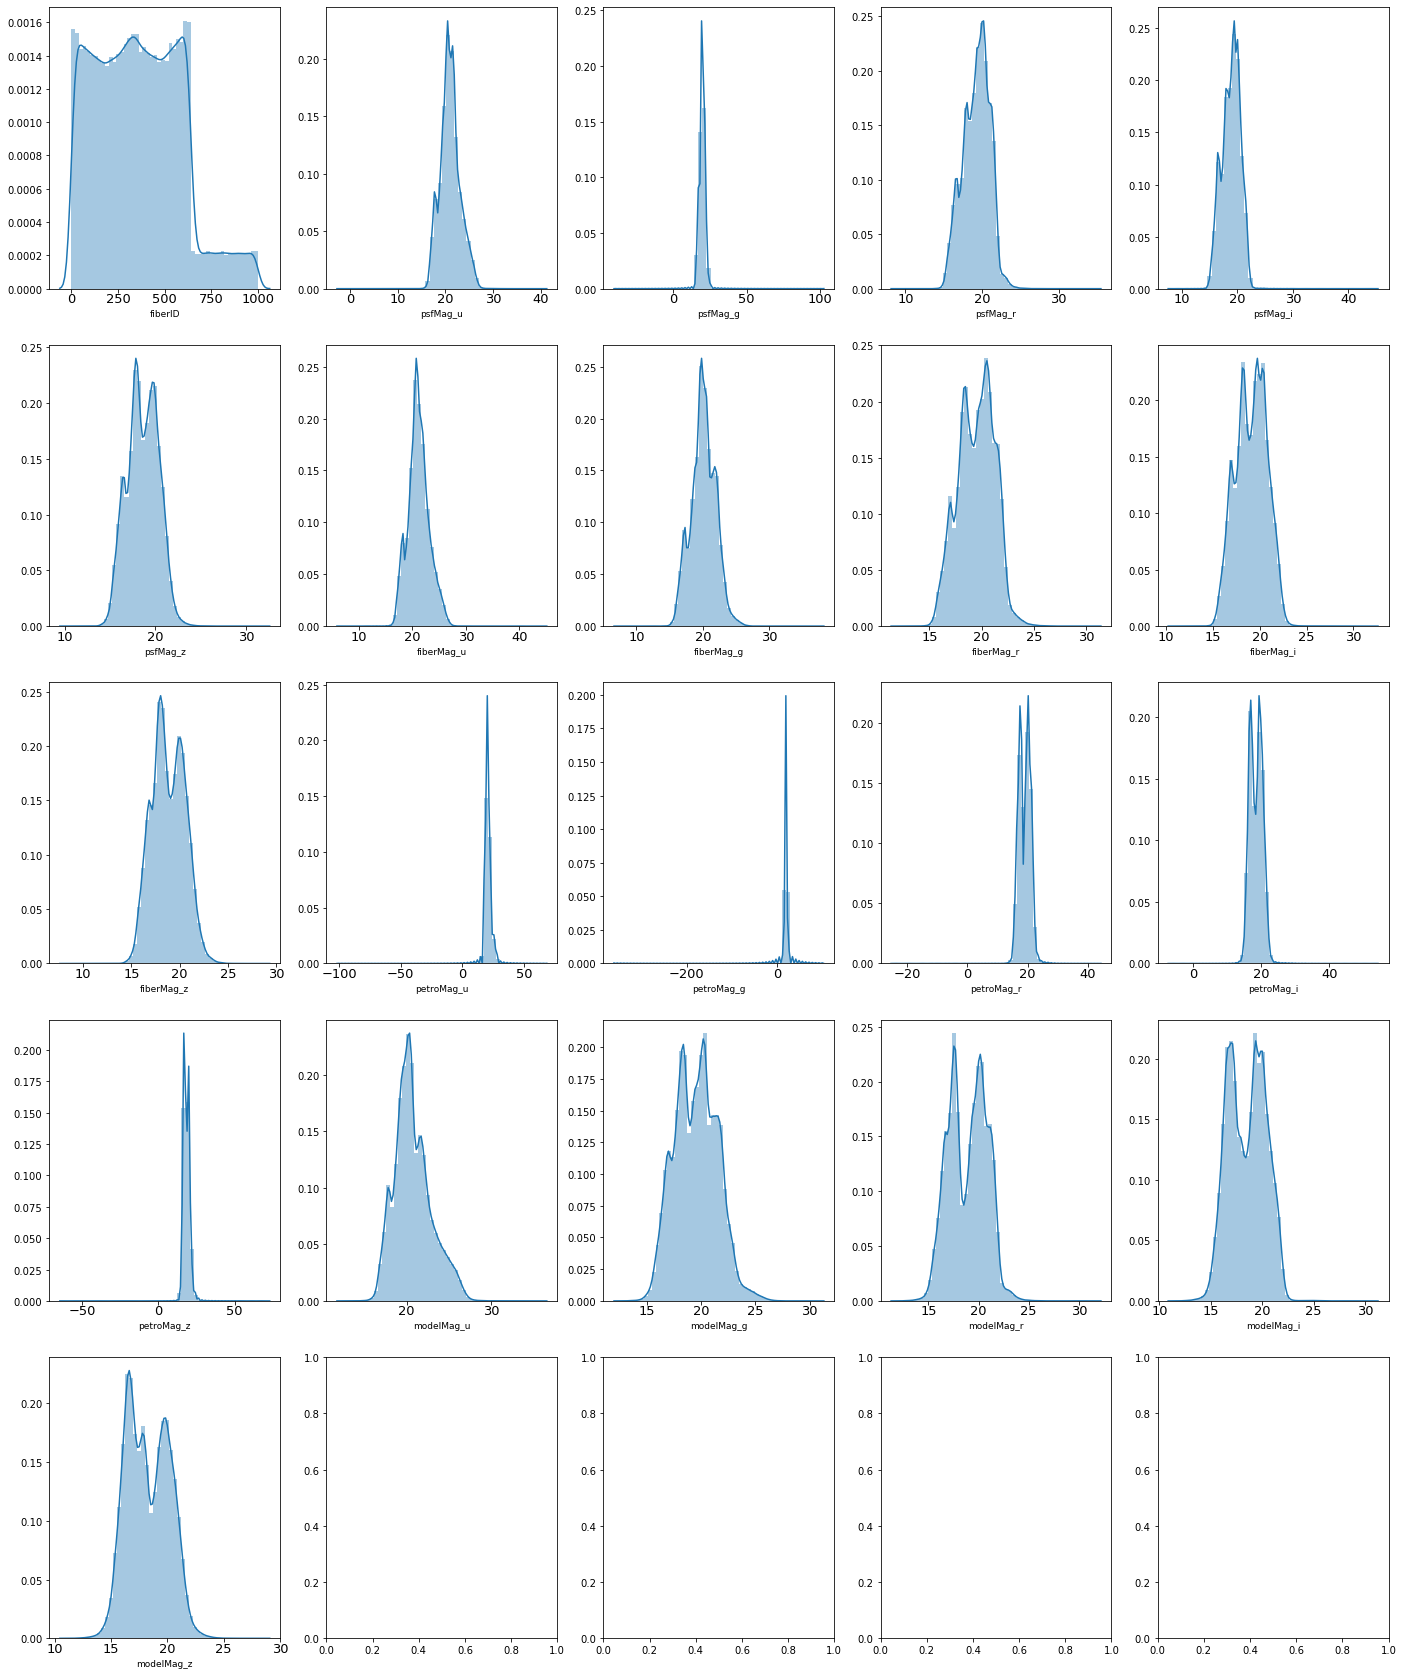

In [150]:
plot_feature_distribution(train, features[0:-1])

In [144]:
data = {"train" : train,
       "test" : test}

In [145]:
with open("data_outlierRemove.pkl","wb") as f:
    pickle.dump(data,f)

fiberID 의 feature importance가 높을 경우 다 나눠서 모델링 해보자

standard scaler 적용해보기
log scaler 적용해보기]
색깔끼리 차이 변수 만들기
빛 종류끼리 차이 변수 만들기

In [158]:
len(light)

20

In [177]:
from  sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_ = pd.concat([train[["id","type","fiberID"]].reset_index(drop=True), pd.DataFrame(scaler.fit_transform(train[light]),columns = light)], axis = 1)

In [178]:
train_

,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,0,8,601,1.066815,0.836398,1.190953,1.420193,1.525187,0.716914,0.844852,...,0.718916,0.749604,1.277090,1.349057,0.990316,0.925289,0.990466,1.305055,1.393861,1.544094
1,1,8,788,0.215869,0.451150,0.817825,1.128658,1.109132,0.354469,0.510744,...,0.260846,0.483027,0.973002,1.080470,1.099675,0.349588,0.628746,0.976639,1.211471,1.202689
2,2,8,427,-1.508258,-1.667200,-1.531000,-1.341471,-1.173961,-1.526099,-1.661638,...,-1.138436,-1.167151,-1.197242,-0.988985,-0.772598,-1.334452,-1.448999,-1.236624,-1.036638,-0.852849
3,3,8,864,-0.093064,0.095769,0.376189,0.599002,0.507314,-0.067622,0.123408,...,-0.110376,0.162303,0.505885,0.608263,0.518509,0.018616,0.241536,0.511604,0.690149,0.686863
4,4,10,612,2.635305,1.702223,1.283315,0.390192,-0.132769,2.303673,1.923613,...,2.062707,1.156123,1.377955,0.533411,-0.007753,1.900370,1.851250,1.364874,0.539215,0.053973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199750,199986,8,568,-0.169698,0.307352,0.448928,0.708149,0.803096,-0.113664,0.346015,...,0.050840,0.383927,0.578744,0.795202,0.685125,0.024382,0.407906,0.578468,0.859502,0.853342
199751,199987,6,362,2.071204,1.568357,1.047436,0.810777,0.586166,2.800680,1.483123,...,3.278846,1.084058,0.560731,0.201807,0.200617,2.837435,1.239579,0.450535,0.262025,0.136042
199752,199988,10,146,1.265048,1.086944,0.613374,-0.255211,-0.765791,1.601779,1.194621,...,2.112034,1.036067,0.683652,-0.052362,-0.474824,1.729170,1.211521,0.797217,-0.042823,-0.507267
199753,199989,6,85,0.090962,0.372969,0.437767,0.568072,0.553317,0.270703,0.206344,...,-0.732472,-0.625241,-0.777521,-0.757141,-0.593500,-0.742833,-0.780032,-0.806593,-0.739229,-0.701817


<Figure size 432x288 with 0 Axes>

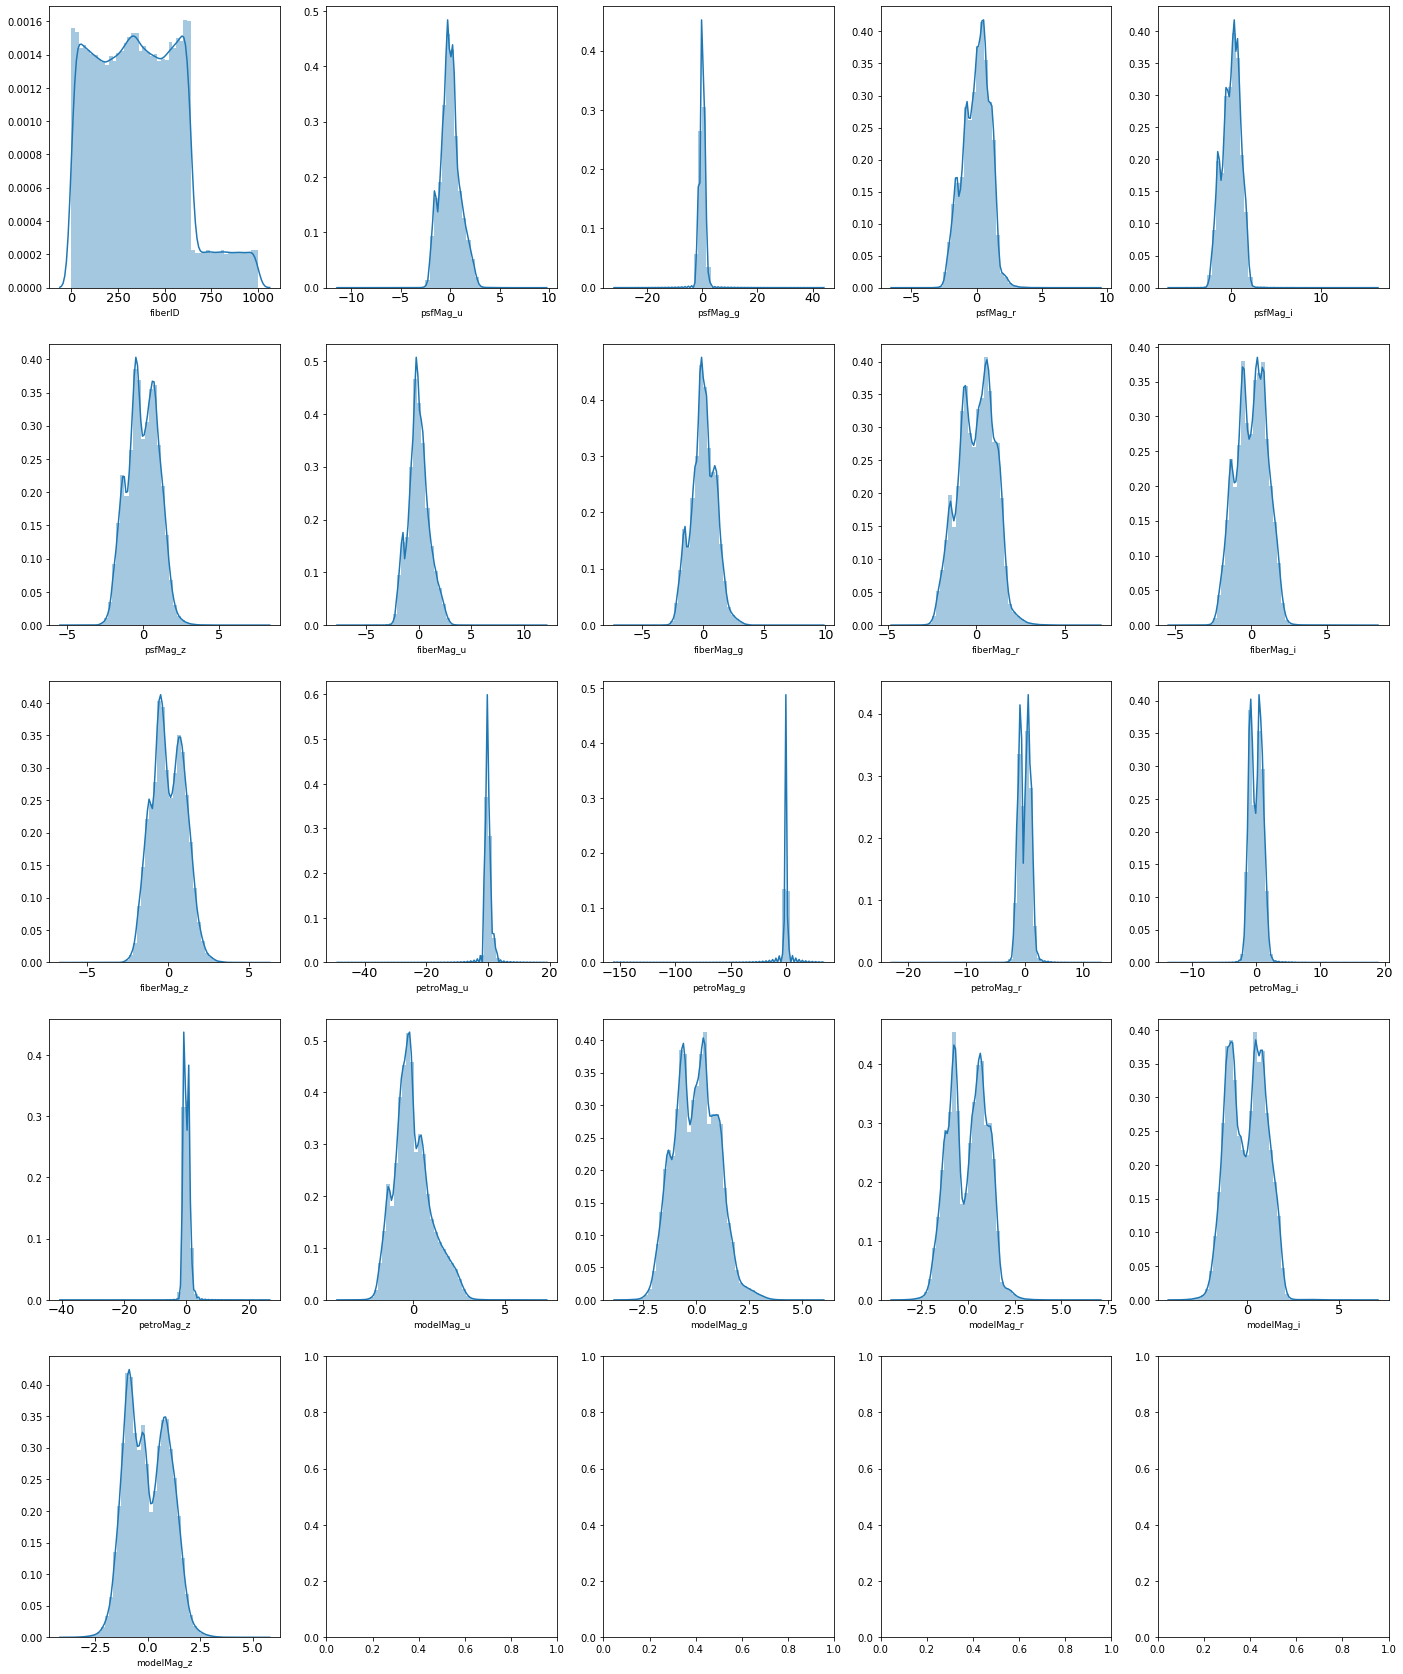

In [181]:
features = [c for c in train_.columns if c not in ["id","type"]]
plot_feature_distribution(train_, features)

C:\Users\ghdbs\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\ghdbs\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


,id,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,-inf,2.079442,6.398595,3.144076,3.064883,3.059371,3.052895,3.052653,3.117123,3.074749,...,3.113707,3.064868,3.067044,3.051423,3.016635,3.124532,3.066449,3.061716,3.045503,3.051514
1,0.000000,2.079442,6.669498,3.064855,3.030525,3.029111,3.030299,3.019118,3.085061,3.045939,...,3.061553,3.033941,3.039256,3.027222,3.027554,3.067725,3.032957,3.032735,3.029814,3.021025
2,0.693147,2.079442,6.056784,2.882085,2.817078,2.814191,2.815088,2.811917,2.899876,2.835158,...,2.882970,2.817728,2.814742,2.818053,2.821855,2.880213,2.815255,2.811884,2.813021,2.814746
3,1.098612,2.079442,6.761573,3.034467,2.997749,2.992071,2.987894,2.968529,3.046379,3.011466,...,3.017196,2.995419,2.995009,2.983200,2.968110,3.033544,2.995817,2.990207,2.983564,2.973121
4,1.386294,2.302585,6.416732,3.275444,3.138046,3.066722,2.970669,2.911758,3.246516,3.162480,...,3.252668,3.110262,3.076093,2.976040,2.911053,3.213946,3.141908,3.066905,2.969765,2.911027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,12.206003,2.079442,6.342121,3.026784,3.017392,2.998267,2.996780,2.993713,3.042068,3.031423,...,3.036701,3.022196,3.002040,3.000860,2.985516,3.034150,3.011944,2.996434,2.998825,2.988834
199987,12.206008,1.791759,5.891644,3.230160,3.127078,3.047840,3.005065,2.975305,3.283827,3.127581,...,3.363684,3.102364,3.000306,2.943691,2.934035,3.292940,3.088878,2.984485,2.943915,2.919300
199988,12.206013,2.302585,4.983607,3.161663,3.086610,3.012134,2.915473,2.852253,3.191333,3.104046,...,3.257419,3.097069,3.012079,2.918167,2.857534,3.198814,3.086377,3.016540,2.914692,2.852539
199989,12.206018,1.791759,4.442651,3.052680,3.023406,2.997319,2.985361,2.972488,3.077502,3.018948,...,2.938145,2.894007,2.862276,2.843783,2.843467,2.950164,2.890648,2.858785,2.844546,2.831438


In [192]:
import re
sameColor = [c for c in train.columns if re.compile(".*_u").match(c)]

In [200]:
df=train
for i in range(len(sameColor)):
    for j in range(len(sameColor)):
        if i >= j :
            pass
        else:
            #print(sameColor[i] + " - " + sameColor[j])
            print(df[sameColor[i]] - df[sameColor[j]])

0         0.616915
1        -0.437442
2        -0.320439
3        -0.249130
4         0.754337
            ...   
199986   -0.317739
199987   -1.393976
199988   -0.710990
199989   -0.532123
199990   -0.307074
Length: 199755, dtype: float64
0         0.693907
1         0.070653
2        -0.015801
3         0.355993
4         0.595740
            ...   
199986   -0.205620
199987   -3.611747
199988   -2.372552
199989    2.291222
199990   -0.171752
Length: 199755, dtype: float64
0         0.448983
1        -0.061600
2         0.033389
3         0.019189
4         1.577917
            ...   
199986   -0.152514
199987   -1.638208
199988   -0.893634
199989    2.062917
199990   -0.123549
Length: 199755, dtype: float64
0         0.076991
1         0.508096
2         0.304637
3         0.605123
4        -0.158597
            ...   
199986    0.112119
199987   -2.217771
199988   -1.661562
199989    2.823345
199990    0.135322
Length: 199755, dtype: float64
0        -0.167933
1         0.375842
2 